In [ ]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize'] = [14,14]

In [ ]:
# load the data
df = pd.read_csv('/Users/snehakj/Documents/netflix/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')

# Check for any parsing failures
invalid_dates = df[df['date_added'].isna() & df['date_added'].notna()]
print("Rows with still invalid 'date_added' values after specifying format:")
print(invalid_dates[['date_added']])

Rows with still invalid 'date_added' values after specifying format:
Empty DataFrame
Columns: [date_added]
Index: []


In [ ]:
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
import math
import time

# Assuming 'df' is already loaded and preprocessed as per your previous steps

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']

vector = TfidfVectorizer(
    max_df=0.4,                 # Drop words that occur in more than X percent of documents
    min_df=1,                   # Only use words that appear at least X times
    stop_words='english',       # Remove stop words
    lowercase=True,             # Convert everything to lower case
    use_idf=True,               # Use idf
    norm='l2',                  # Normalization
    smooth_idf=True             # Prevents divide-by-zero errors
)

tfidf = vector.fit_transform(text_content)

# Clustering with KMeans
k = 200
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)  # It's good practice to set random_state for reproducibility
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vector.get_feature_names_out()  # Updated method

# Optional: Print the centers of the clusters
# for i in range(k):
#     word_list = [terms[j] for j in centers[i, :10]]
#     print(f"Cluster {i}: {word_list}")

# Transform the descriptions and assign clusters
request_transform = vector.transform(df['description'])
df['cluster'] = kmeans.predict(request_transform)

# Display the top cluster counts
print(df['cluster'].value_counts().head())

cluster
63     5211
52      210
21      200
184     189
142     134
Name: count, dtype: int64


In [ ]:
# Find similar : get the top_n movies with description similar to the target description
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [ ]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.003579854965209961 seconds --
 iter 1000 -- 0.7096238136291504 seconds --
 iter 2000 -- 1.4114649295806885 seconds --
 iter 3000 -- 2.1046369075775146 seconds --
 iter 4000 -- 2.789320945739746 seconds --
 iter 5000 -- 3.4995179176330566 seconds --
 iter 6000 -- 4.230337858200073 seconds --
 finish -- 4.391924858093262 seconds --


In [ ]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

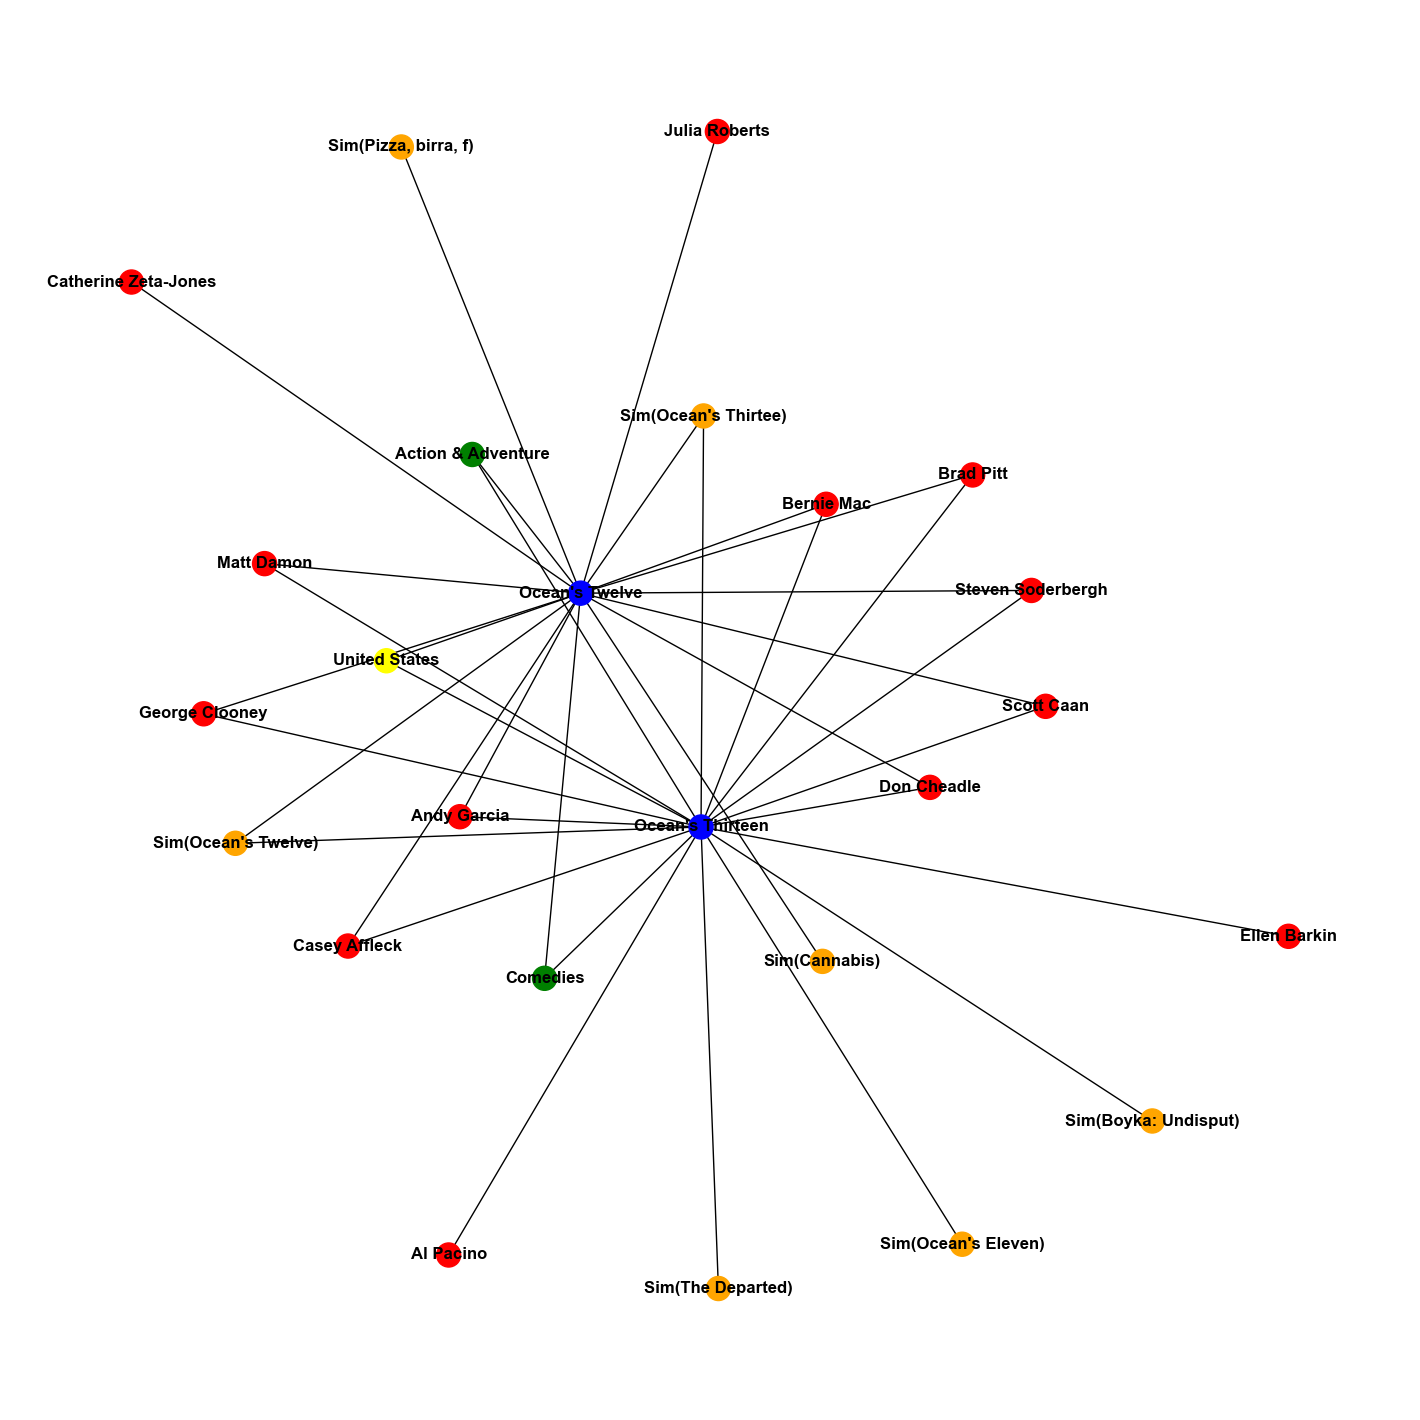

In [ ]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [ ]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result;

In [ ]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Autopsy of Jane Doe                  1.032475
The Diabolical                           1.032475
dtype: float64
****************************************
 Recommenda

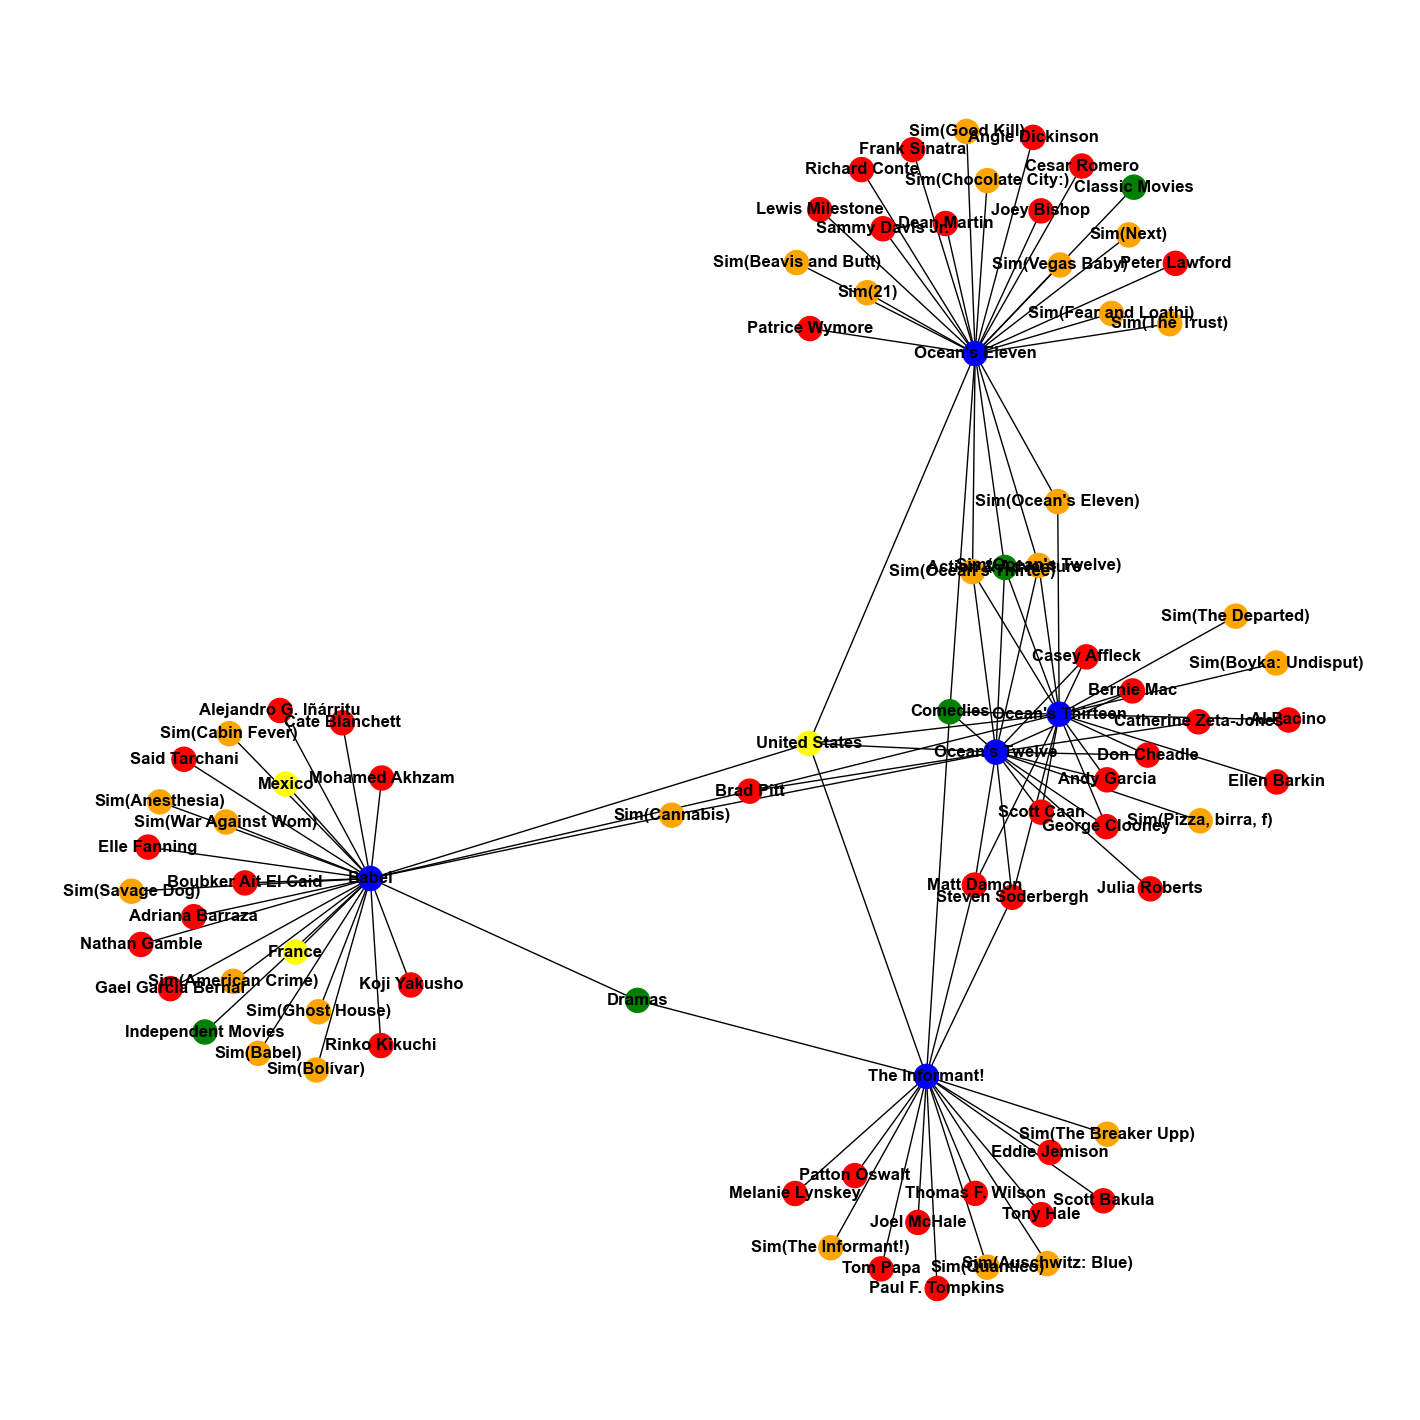

In [ ]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

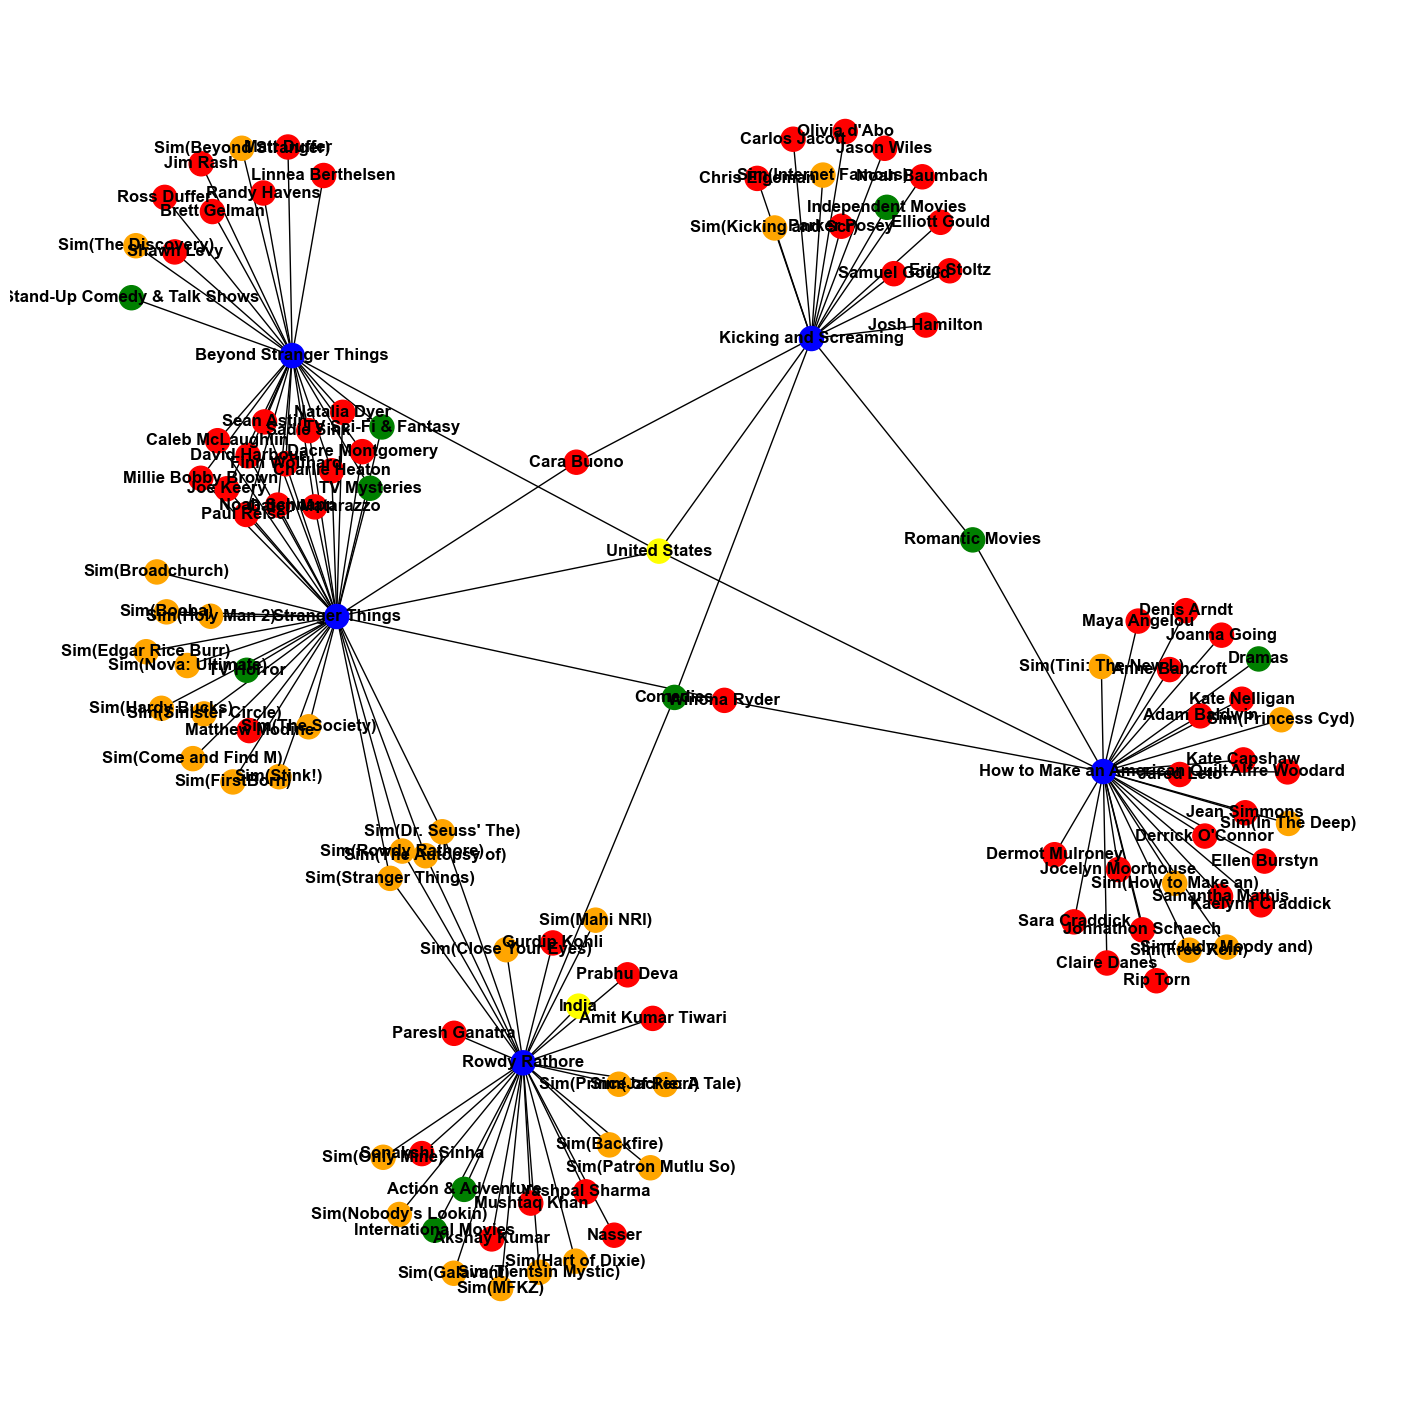

In [ ]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

In [ ]:
# Split the DataFrame into TV Shows and Movies
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]

In [ ]:
# Create 'first_country' using the preprocessed 'countries' list
df['first_country'] = df['countries'].apply(lambda x: x[0] if x else 'Unknown')

# Count the number of movies per country
country_movie_counts = df_movies['first_country'].value_counts().head(10).reset_index()
country_movie_counts.columns = ['first_country', 'count']

print("\nTop 10 Countries by Movie Count:")
print(country_movie_counts)


Top 10 Countries by Movie Count:
    first_country  count
0   United States   1682
1           India    753
2  United Kingdom    282
3         Unknown    195
4          Canada    130
5           Spain    100
6          France     97
7       Hong Kong     71
8          Mexico     66
9          Turkey     58


In [ ]:
# Extract the top 10 countries
top_countries = country_movie_counts['first_country']

# Filter movies belonging to the top 10 countries
df_top_countries = df_movies[df_movies['first_country'].isin(top_countries)]

/var/folders/t2/9jf6fd0d0rv9wnd_67lqth_m0000gn/T/ipykernel_11292/2845985529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_countries['release_year'] = pd.to_numeric(df_top_countries['release_year'], errors='coerce')


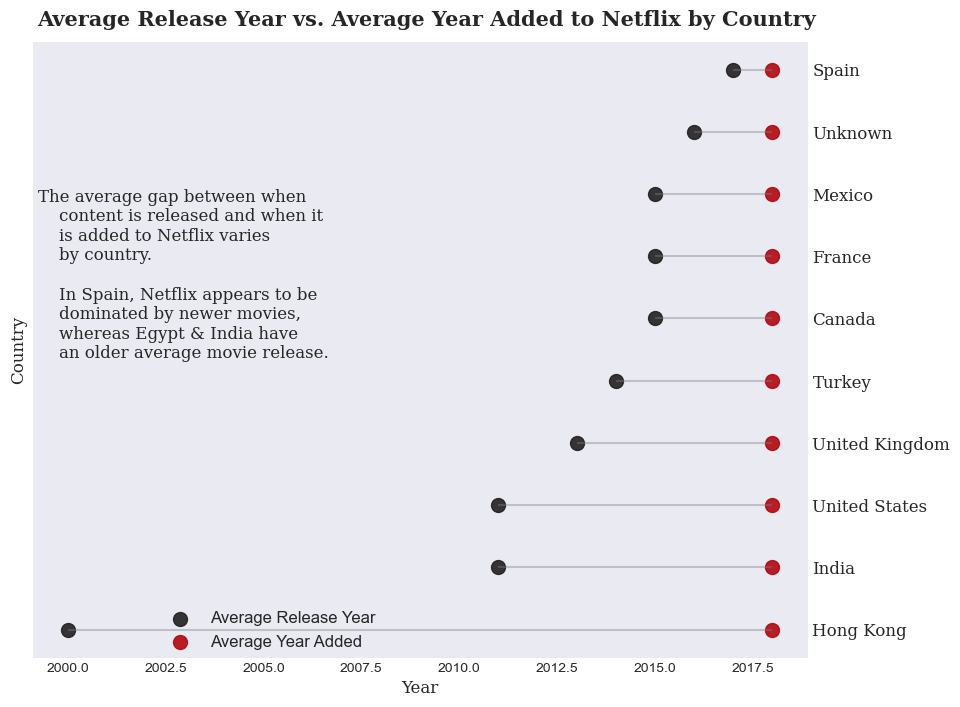

In [ ]:
# Ensure 'release_year' exists and is numeric
if 'release_year' not in df_top_countries.columns:
    print("Error: 'release_year' column is missing.")
else:
    # Convert 'release_year' to numeric if it's not
    df_top_countries['release_year'] = pd.to_numeric(df_top_countries['release_year'], errors='coerce')

    # Group by 'first_country' and calculate mean release_year and mean year_added
    country_averages = df_top_countries.groupby('first_country')[['release_year', 'year']].mean().round()

    # Sort the DataFrame by 'release_year'
    ordered_df = country_averages.sort_values(by='release_year')

    # Alternatively, sort by 'release_year' descending
    ordered_df_rev = country_averages.sort_values(by='release_year', ascending=False)

    # Define the range for Y-axis based on the number of countries
    my_range = range(1, len(ordered_df.index) + 1)

    # ============================
    # 4. Visualization
    # ============================

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Add title
    fig.text(0.13, 0.9, 'Average Release Year vs. Average Year Added to Netflix by Country', fontsize=15, fontweight='bold', fontfamily='serif')

    # Plot horizontal lines between release_year and year_added
    ax.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year'], color='grey', alpha=0.4)

    # Plot average release_year
    scatter_release = ax.scatter(
        ordered_df['release_year'],
        my_range,
        color='#221f1f',
        s=100,
        alpha=0.9,
        label='Average Release Year'
    )

    # Plot average year_added
    scatter_added = ax.scatter(
        ordered_df['year'],
        my_range,
        color='#b20710',
        s=100,
        alpha=0.9,
        label='Average Year Added'
    )

    # Customize spines
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_visible(False)

    # Remove tick marks but keep labels
    ax.tick_params(axis='both', which='both', length=0)

    # Move Y-axis to the right
    ax.yaxis.tick_right()

    # Set Y-axis labels to country names
    ax.set_yticks(my_range)
    ax.set_yticklabels(ordered_df.index, fontname="serif", fontsize=12)

    # Add custom legend
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(0.15, 0.1),
        frameon=False,
        fontsize=12
    )

    # Add descriptive text
    fig.text(0.13, 0.46,
    '''The average gap between when
    content is released and when it
    is added to Netflix varies
    by country.

    In Spain, Netflix appears to be
    dominated by newer movies,
    whereas Egypt & India have
    an older average movie release.
    '''
    , fontsize=12, fontweight='light', fontfamily='serif')

    # Display the plot
    plt.xlabel('Year', fontsize=12, fontfamily='serif')
    plt.ylabel('Country', fontsize=12, fontfamily='serif')
    plt.show()